In [ ]:
!git clone https://github.com/lyap-ai/torchSODE.git

In [ ]:
!cd ../src/ && python3 setup.py install

In [ ]:
!git clone https://github.com/rtqichen/torchdiffeq
!cd torchdiffeq && pip install -e .

In [ ]:
!pip install ipyexperiments

In [1]:
import ipyexperiments
import timeit
import time
from functools import partial

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
import torchSODE
import torchdiffeq
import csv

In [3]:
torch.cuda.manual_seed_all(2)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Creating dataset

In [5]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [6]:
def gen_dataset(data, number):
    if data == 'blobs':
        X,yn = datasets.make_blobs(n_samples=2048, centers = 2,n_features=2, cluster_std=4)
        plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
        plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
    if data == 'moons':
        X, yn = datasets.make_moons(n_samples=10)
        plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
        plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
    if data == 'mclass':
        X, yn = datasets.make_classification(n_samples=500,n_informative=4,n_clusters_per_class=3,n_classes=3)
        plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
        plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
        plt.scatter(X[yn==2,0],X[yn==2,1],color='green')
    if data == 'spirals':
        X, yn = twospirals(512)
        plt.title('training set')
        plt.plot(X[yn==0,0], X[yn==0,1], '.', label='class 1')
        plt.plot(X[yn==1,0], X[yn==1,1], '.', label='class 2')
        plt.legend()
    filename = 'data-cluster-' + number
    plt.savefig(filename + '.png')

    with open(filename + '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "X", "Y"])
        for i in range(1024):
            writer.writerow(['blue',  str(X[yn==1,0][i]), str(X[yn==1,1][i])])
            
        for i in range(1024):
            writer.writerow(['red',  str(X[yn==0,0][i]), str(X[yn==0,1][i])])
    return X, yn

In [7]:
def setup(X, yn):
    X_train, X_test, y_train, y_test = train_test_split(X, yn, test_size=0.5)
    # choose batch size here
    bs = 128

    X_train = torch.Tensor(X_train).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    X_test = torch.Tensor(X_test).to(device)
    y_test = torch.LongTensor(y_test).to(device)

    train = data_utils.TensorDataset(X_train,y_train)
    trainloader = data_utils.DataLoader(train, batch_size=bs, shuffle=True)

    test = data_utils.TensorDataset(X_test,y_test)
    testloader = data_utils.DataLoader(test, batch_size=bs, shuffle=True)
    return trainloader, testloader

# Neural Network definition

In [8]:
class MLP(nn.Module):
    def __init__(self, dense_layers, softmax = True):
        '''
        Simple dense MLP class used as predictor
        
        :smax_l: leave True for softmax applied to ouput
        '''
        super().__init__()
        self.dense_layers = nn.ModuleList([nn.Linear(dense_layers[i], dense_layers[i + 1]) \
                                           for i in range(len(dense_layers) - 1)])
        self.softmax = softmax
        
    def getLength(self):
        return len(self.dense_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.dense_layers:
            l_x = l(x)
            x = F.relu(l_x)
        if not self.softmax: return l_x
        else: return F.log_softmax(l_x, dim=-1)

In [9]:
def count_parameters(model):
    return "Total parameters " + str(sum(p.numel() for p in model.parameters() if p.requires_grad))

In [10]:
# util to generate F matrix
def generateFS(size, UL, UR, LL, LR):
  n = size//2
  ul = UL*torch.eye(n)
  ur = UR*torch.eye(n) 
  ll = LL*torch.eye(n)
  lr = LR*torch.eye(n)
  top = torch.cat((ul, ur),1)
  bottom = torch.cat((ll, lr),1)
  return torch.cat((top, bottom), 0)

## Experiment definition

In [44]:
#torchSODE SGD-like
def torchsodeT1(trainloader, m1):
    Fm = torch.eye(1).to(device)
    criterion = F.nll_loss
    optimizer = torch.optim.SGD(m1.parameters(), lr=0.01, momentum=0.9)
    epochs = 100
    dt = 0.001 
    ode_steps = 1
    # timer for updating loop only
    end_updating_timer1 = 0

    training_timer1 = time.process_time()
    for e in range(epochs):
        dataiter = iter(trainloader)

        for i, d in enumerate(dataiter):
            x, y = next(dataiter)
            x, y = x.cuda(), y.cuda()
            for j in range(ode_steps):
                loss = criterion(m1(x), y)
                loss.backward()
                updating_timer1 = time.process_time()
                with torch.no_grad():
                    for p in m1.parameters():
                        torchSODE.solve(-Fm, p.view(-1), p.grad.view(-1), dt, 1, 'Euler', 1e-8, 1e-8)
                end_updating_timer1 += time.process_time() - updating_timer1
            m1.zero_grad()

    end_training1 = time.process_time() - training_timer1
    print(f"Entire training process took {round(end_training1, 4)} (s)")
    print(f"Updating the parameters took {round(end_updating_timer1, 4)} (s)")
    return end_training1, end_updating_timer1

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.002
･ CPU:          0          0      1,808 MB |
･ GPU:          0          0      2,302 MB |


In [43]:
# torchSODE with less params (for torchdiffeq)
def torchsodeT2(trainloader, m1_small):
    Fm = torch.eye(1).to(device)
    criterion = F.nll_loss
    optimizer = torch.optim.SGD(m1.parameters(), lr=0.01, momentum=0.9)
    epochs = 100
    dt = 0.01 
    ode_steps = 1
    # timer for updating loop only
    end_updating_timer1 = 0

    training_timer1 = time.process_time()
    for e in range(epochs):
        dataiter = iter(trainloader)

        for i, d in enumerate(dataiter):
            x, y = next(dataiter)
            x, y = x.cuda(), y.cuda()
            for j in range(ode_steps):
                loss = criterion(m1_small(x), y)
                loss.backward()
                updating_timer1 = time.process_time()
                with torch.no_grad():
                    for p in m1_small.parameters():
                        torchSODE.solve(-Fm, p.view(-1), p.grad.view(-1), dt, 1, 'Euler', 1e-8, 1e-8)
                end_updating_timer1 += time.process_time() - updating_timer1
            m1_small.zero_grad()

    end_training1 = time.process_time() - training_timer1
    print(f"Entire training process took {round(end_training1, 4)} (s)")
    print(f"Updating the parameters took {round(end_updating_timer1, 4)} (s)")
    return end_training1, end_updating_timer1

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.002
･ CPU:          0          0      1,808 MB |
･ GPU:          0          0      2,302 MB |


In [42]:
#torch.optim SGD and SGD with momentum 
def torchoptim(trainloader, m2):
    m2 = MLP([2, 10000, 10000, 1000, 1000, 2]).to(device)
    criterion = F.nll_loss
    optimizer = torch.optim.SGD(m2.parameters(), lr=0.01, momentum=0.9)
    epochs = 100
    dt = 0.01 
    ode_steps = 1
    # timer for updating loop only
    end_updating_timer2 = 0

    training_timer2 = time.process_time()
    for e in range(epochs):
        dataiter = iter(trainloader)

        for i, d in enumerate(dataiter):
            x, y = next(dataiter)
            x, y = x.cuda(), y.cuda()
            loss = criterion(m2(x), y)
            loss.backward()
            updating_timer2 = time.process_time()
            optimizer.step() 
            end_updating_timer2 += time.process_time() - updating_timer2
            optimizer.zero_grad()

    end_training2 = time.process_time() - training_timer2
    print(f"Entire training process took {round(end_training2, 4)} (s)")
    print(f"Updating the parameters took {round(end_updating_timer2, 4)} (s)")
    return end_training2, end_updating_timer2

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.002
･ CPU:          0          0      1,808 MB |
･ GPU:          0          0      2,302 MB |


In [14]:
# model class for torchdiffeq

class SparseBlockModel(object):
    def __init__(self, F, numpy=True):
        if numpy: F = F.numpy()
        self.F = F[0][0]
    def __call__(self, dt, x, grad=None):
        dxdt = self.F * grad * x
        return dxdt

In [41]:
#torchdiff SGD-like
def torchdiff(trainloader, m3):
    Fm = torch.eye(1).to(device)
    model = SparseBlockModel(Fm, False)
    criterion = F.nll_loss
    optimizer = torch.optim.SGD(m3.parameters(), lr=0.01, momentum=0.9)
    epochs = 100
    t = torch.linspace(0, 0.01)
    ode_steps = 1

    # timer for updating loop only
    end_updating_timer3 = 0

    training_timer3 = time.process_time()
    for e in range(epochs):
        dataiter = iter(trainloader)

        for i, d in enumerate(dataiter):
            x, y = next(dataiter)
            x, y = x.cuda(), y.cuda()
            for j in range(ode_steps):
                loss = criterion(m3(x), y)
                loss.backward()
                updating_timer3 = time.process_time()
                with torch.no_grad():
                    for p in m3.parameters():
                        p = torchdiffeq.odeint(partial(model, grad=p.grad.view(-1)), p.view(-1), t, method='euler')
                end_updating_timer3 += time.process_time() - updating_timer3
            m3.zero_grad()

    end_training3 = time.process_time() - training_timer3
    print(f"Entire training process took {round(end_training3, 4)} (s)")
    print(f"Updating the parameters took {round(end_updating_timer3, 4)} (s)")
    return end_training3, end_updating_timer3

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.003
･ CPU:          0          0      1,808 MB |
･ GPU:          0          0      2,303 MB |


# Boundary definition

In [16]:
def genpoints(xmin,xmax,ymin,ymax,number_points):
    xx = torch.linspace(xmin,xmax,number_points)
    yy = torch.linspace(ymin,ymax,number_points)
    c = 1
    P = []
    for i in range(number_points):
        for j in range(number_points):
            P.append([xx[i],yy[j]])
    return torch.Tensor(P).cuda()

In [17]:
def gen_boundary(X, yn, m1, number):
    mp = genpoints(-20,25,-20,25,100)
    y, idx = torch.max(torch.exp(m1.forward(mp)), 1)
    mp_r = mp[idx==0]
    mp_b = mp[idx==1]
    plt.figure(figsize=(4.5,4))
    plt.scatter(mp_r[:,0].cpu(),mp_r[:,1].cpu(),color='orange')
    plt.scatter(mp_b[:,0].cpu(),mp_b[:,1].cpu(),color='cyan')
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
    plt.savefig('data-cluster-boundary-' + number + '.png')
    plt.show()

# Plot definition

In [3]:
def trainingchart(torchdiag_tot, torchdiag_tr, number):
    torchdiag_diff = torchdiag_tot - torchdiag_tr
    width = 0.45
    y_pos = np.arange(3)
    plt.bar(y_pos, torchdiag_diff, width, color='blue')
    plt.bar(y_pos, torchdiag_tr, width, bottom=torchdiag_diff, color='green')
    plt.legend(['Other', 'Update'])
    ax = plt.gca()
    ax.set_xticklabels(['', 'torchdiffeq-3', '', 'torchSODE-3', '', 'torchSODE-100'])
    plt.ylabel('time / 100 epochs')
    # plt.yscale('log')
    plt.title('Training (diagonal - SGD)')
    plt.savefig('trainingchart-' + number + '.png')
    plt.show()

In [4]:
def torch_mem(memory, number):
    width = 0.45
    y_pos = np.arange(3)
    plt.bar(y_pos, memory, width, color='orange')
    plt.title('GPU memory used for training (MB)')
    ax = plt.gca()
    ax.set_xticklabels(['', 'torchdiffeq-3', '', 'torchSODE-3', '', 'torchSODE-100'])
    plt.savefig('torchmem-' + number + '.png')
    plt.show()

# Training

# Experiment 1

In [21]:
exp1 = ipyexperiments.IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, TITAN RTX (24217 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   1,564  13,033  15,953 MB   9.80% 
GPU:   1,258  22,958  24,217 MB   5.20% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.000
･ CPU:          0          0      1,565 MB |
･ GPU:          0          0      1,258 MB |


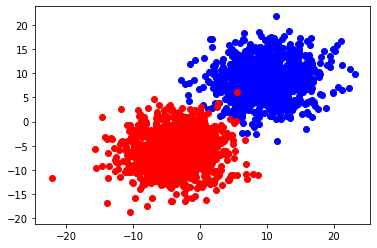

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.259
･ CPU:          0          0      1,794 MB |
･ GPU:          0          0      2,282 MB |


In [24]:
X, yn = gen_dataset('blobs', '0')

## torchSODE

In [46]:
m1 = MLP([2, 10000, 10000, 1000, 1000, 2]).to(device)
count_parameters(m1)
trainloader, _ = setup(X, yn)
t_train1, t_update1 = torchsodeT1(trainloader, m1)

Entire training process took 6.4971 (s)
Updating the parameters took 5.5074 (s)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:06.897
･ CPU:          0          0      1,808 MB |
･ GPU:          0        424      2,302 MB |


## torchSODE with less params (for torchdiffeq)

In [47]:
m1_small = MLP([2, 1000, 1000, 1000, 1000, 2]).to(device)
count_parameters(m1_small)
trainloader, _ = setup(X, yn)
t_train2, t_update2 = torchsodeT2(trainloader, m1_small)

Entire training process took 1.4762 (s)
Updating the parameters took 0.5136 (s)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:01.399
･ CPU:          0          0      1,816 MB |
･ GPU:        -20          4      2,282 MB |


## torchdiffeq with small model

In [49]:
count_parameters(m1_small)
trainloader, _ = setup(X, yn)
t_train4, t_update4 = torchdiff(trainloader, m1_small)

Entire training process took 62.4137 (s)
Updating the parameters took 61.438 (s)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:01:00.815
･ CPU:          0          0      1,816 MB |
･ GPU:          0        786      2,283 MB |


# Boundary plot

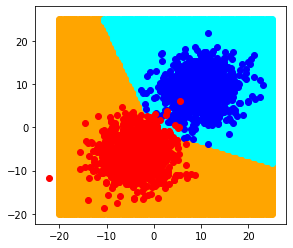

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.547
･ CPU:          0          2      1,816 MB |
･ GPU:          0      1,688      2,283 MB |


In [50]:
gen_boundary(X, yn, m1, '0')

# Plots

[62.4137  1.4762  6.4971]
[61.438   0.5136  5.5074]


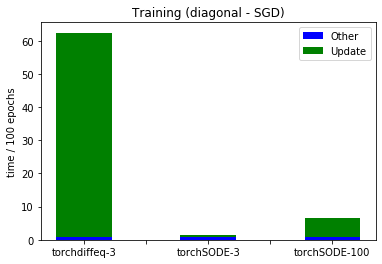

In [6]:
torchdiag_tot = np.array([62.4137, 1.4762, 6.4971])
torchdiag_tr = np.array([61.438, 0.5136, 5.5074])
print(torchdiag_tot)
print(torchdiag_tr)
trainingchart(torchdiag_tot, torchdiag_tr, '0')

[786  24 424]


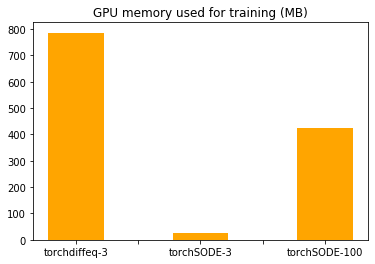

In [9]:
memory = np.array([786, 24, 424])
print(memory)
torch_mem(memory, '0')

In [58]:
del exp1

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.001
･ CPU:          0          0      1,816 MB |
･ GPU:          0          0      2,283 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:19:06 (elapsed wallclock time)

*** Newly defined local variables:
Deleted: X, m1, m1_small, memory, t_train1, t_train2, t_train3, t_train4, t_update1, t_update2, t_update3, t_update4, torch_tot_sk, torch_tr_sk, torchdiag_tot, torchdiag_tr, trainloader, yn

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:      252        0 MB (  0.00%)
GPU:    1,024      884 MB ( 86.31%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   1,816  12,812  15,953 MB  11.39% 
GPU:   1,399  22,818  24,217 MB   5.78% 


